<a href="https://colab.research.google.com/github/yudumpacin/NLPStudyNotes/blob/main/TextClassificationwithGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code is heavily inspired from [Sebastian Raschka](https://x.com/rasbt)'s excellent book, "[Build a Large Language Model (From Scratch)](https://www.manning.com/books/build-a-large-language-model-from-scratch)".

 Moreover inspired by [viraat](https://x.com/virattt)'s [spam classificationcolab notebook](https://colab.research.google.com/gist/virattt/ddb43fc3d6c0c66abe29a158fe79aa85/finetuned-spam-classifier.ipynb)

I changed this notebook to a multiclass classification training model with Turkish new classification dataset


In [1]:
!pip install tensorflow>=2.15.0  tqdm>=4.66 tiktoken --quiet

## 1. Download GPT-2 weights

In [1]:
import urllib.request
url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x7c406c1a6170>)

In [2]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(
    model_size="124M", models_dir="gpt2"
)

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


## 2. Inspect the model

In [3]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


## 3. Set model configuration

In [4]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

In [5]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [6]:
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])

In [7]:
NEW_CONFIG.update({"context_length": 1024})
NEW_CONFIG.update({"qkv_bias": True})

## 4. Implement layer normalization module

In [8]:
import torch
import torch.nn as nn

class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True, unbiased=False)
    normalized_x = (x - mean) / torch.sqrt(var + self.eps)
    return self.scale * normalized_x + self.shift

## 5. Define multi-head attention block

In [9]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
    super().__init__()

    assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

    self.d_out = d_out                  # 768
    self.num_heads = num_heads          # 12
    self.head_dim = d_out // num_heads  # 64
    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.out_proj = nn.Linear(d_out, d_out)
    self.dropout = nn.Dropout(dropout)
    self.register_buffer(
        'mask',
        torch.triu(torch.ones(
            context_length,             # 1024
            context_length,             # 1024
          ), diagonal=1)
    )

  def forward(self, x):
    batch_size, num_tokens, embedding_length = x.shape
    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)

    # Add the num_heads and head_dim dimensions
    keys = keys.view(batch_size, num_tokens, self.num_heads, self.head_dim)       # Transform to a tensor of dimensions: 2 x 1024 x 12 x 64
    queries = queries.view(batch_size, num_tokens, self.num_heads, self.head_dim) # Transform to a tensor of dimensions: 2 x 1024 x 12 x 64
    values = values.view(batch_size, num_tokens, self.num_heads, self.head_dim)   # Transform to a tensor of dimensions: 2 x 1024 x 12 x 64

    # Transpose from (batch_size, num_tokens, num_heads, head_dim) to (batch_size, num_heads, num_tokens, head_dim)
    queries = queries.transpose(1, 2)
    keys = keys.transpose(1, 2)
    values = values.transpose(1, 2)

    # Calculate attention scores
    attention_scores = queries @ keys.transpose(2, 3)
    mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

    # Mask the attention scores
    attention_scores.masked_fill_(mask_bool, -torch.inf)

    # Calculate attention weights
    attention_weights = torch.softmax(attention_scores / keys.shape[-1]**0.5, dim=-1)

    # Apply dropout to attention weights
    attention_weights = self.dropout(attention_weights)

    # Calculate context vectors
    context_vectors = (attention_weights @ values).transpose(1, 2)

    # Concatenate the context vectors
    context_vectors = context_vectors.contiguous().view(batch_size, num_tokens, self.d_out)
    return self.out_proj(context_vectors)

## 6. Implement feed-forward network

In [10]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [11]:
# Implement feed-forward neural network
class FeedForward(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(config["emb_dim"], 4 * config["emb_dim"]),
        GELU(),
        nn.Linear(4 * config["emb_dim"], config["emb_dim"]),
    )

  def forward(self, x):
    return self.layers(x)

## 7. Implement transformer block

In [12]:
class TransformerBlock(nn.Module):
  def __init__(self, config):
    super().__init__()

    self.attention = MultiHeadAttention(
        d_in=config["emb_dim"],
        d_out=config["emb_dim"],
        context_length=config["context_length"],
        dropout=config["drop_rate"],
        num_heads=config["n_heads"],
        qkv_bias=config["qkv_bias"]
    )

    self.ff = FeedForward(config)
    self.norm1 = LayerNorm(config["emb_dim"])
    self.norm2 = LayerNorm(config["emb_dim"])
    self.drop_shortcut = nn.Dropout(config["drop_rate"])

  def forward(self, x):
    shortcut = x

    # Attention layer
    x = self.norm1(x)
    x = self.attention(x)
    x = self.drop_shortcut(x)
    x = x + shortcut         # Add the original input back

    # Feedforward layer
    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = x + shortcut         # Add the original input back
    return x

## 8. Implement GPT model

In [13]:
class GPTModel(nn.Module):
  def __init__(self, config):
    super().__init__()

    self.token_embedding = nn.Embedding(config["vocab_size"], config["emb_dim"])
    self.positional_embedding = nn.Embedding(config["context_length"], config["emb_dim"])
    self.drop_embedding = nn.Dropout(config["drop_rate"])

    self.trf_blocks = nn.Sequential(
        *[TransformerBlock(config) for _ in range(config["n_layers"])]
    )

    self.final_norm = LayerNorm(config["emb_dim"])
    self.out_head = nn.Linear(config["emb_dim"], config["vocab_size"], bias=False)

  def forward(self, in_idx):
    batch_size, sequence_length = in_idx.shape
    token_embeddings = self.token_embedding(in_idx)
    positional_embeddings = self.positional_embedding(
        torch.arange(sequence_length, device=in_idx.device)
    )
    x = token_embeddings + positional_embeddings
    x = self.drop_embedding(x)

    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

## 9. Implement function for loading weights

In [14]:
# Load the weights
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, "
                          "Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.positional_embedding.weight = assign(gpt.positional_embedding.weight, params['wpe'])
    gpt.token_embedding.weight = assign(gpt.token_embedding.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].attention.W_query.weight = assign(
            gpt.trf_blocks[b].attention.W_query.weight, q_w.T)
        gpt.trf_blocks[b].attention.W_key.weight = assign(
            gpt.trf_blocks[b].attention.W_key.weight, k_w.T)
        gpt.trf_blocks[b].attention.W_value.weight = assign(
            gpt.trf_blocks[b].attention.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].attention.W_query.bias = assign(
            gpt.trf_blocks[b].attention.W_query.bias, q_b)
        gpt.trf_blocks[b].attention.W_key.bias = assign(
            gpt.trf_blocks[b].attention.W_key.bias, k_b)
        gpt.trf_blocks[b].attention.W_value.bias = assign(
            gpt.trf_blocks[b].attention.W_value.bias, v_b)

        gpt.trf_blocks[b].attention.out_proj.weight = assign(
            gpt.trf_blocks[b].attention.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].attention.out_proj.bias = assign(
            gpt.trf_blocks[b].attention.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

## 10. Implement model helper functions

In [15]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [16]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    # .unsqueeze(0) adds the batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # Remove batch dimension
    return tokenizer.decode(flat.tolist())

tokenizer = tiktoken.get_encoding("gpt2")

## 11. Download finetuning dataset

In [17]:

import pandas as pd

In [18]:
!pip install -q kaggle
!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle


!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d savasy/ttc4900

!unzip /content/ttc4900

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/savasy/ttc4900
License(s): CC0-1.0
ttc4900.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/ttc4900.zip
replace 7allV03.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: 7allV03.csv             


In [19]:

df = pd.read_csv("/content/7allV03.csv")
df

,category,text
0,siyaset,3 milyon ile ön seçim vaadi mhp nin 10 olağan...
1,siyaset,mesut_yılmaz yüce_divan da ceza alabilirdi pr...
2,siyaset,disko lar kaldırılıyor başbakan_yardımcısı ar...
3,siyaset,sarıgül anayasa_mahkemesi ne gidiyor mustafa_...
4,siyaset,erdoğan idamın bir haklılık sebebi var demek ...
...,...,...
4895,teknoloji,iphone lara geri dönüyor ios 6 sürümüyle tele...
4896,teknoloji,muslukta devrim sadece elimizi yıkadığımız mu...
4897,teknoloji,halka iyi anlatılmalı bilgi_teknolojileri ile...
4898,teknoloji,çöpe gidiyorlar apple 775 bin uygulamayla app...


In [20]:
import re

In [21]:
def preprocess_for_training(text_data):
  text_data = re.sub("[^a-zA-ZğüşöçıİĞÜŞÖÇ0-9.,;:!?'\" ]"," ",text_data)
  return text_data

In [22]:
df["text"]= df["text"].apply(preprocess_for_training)

In [23]:
df["category"]=df["category"].str.strip()

In [24]:
# Examine class distributions
print(df["category"].value_counts())

category
siyaset      700
dunya        700
ekonomi      700
kultur       700
saglik       700
spor         700
teknoloji    700
Name: count, dtype: int64


In [25]:
# Convert the "Label" column into 0 or 1 (for "ham" or "spam")
df["category"]=df["category"].astype("category")
df["category_id"] = df["category"].cat.codes

id_to_category = pd.Series(df.category.values,index=df.category_id).to_dict()

category_to_id= {v:k for k,v in id_to_category.items()}

In [26]:
# Split the dataset into train, test, val
def random_split(df, train_frac, validation_frac):
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)


    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(df, 0.7, 0.1)

In [27]:
# Save dataset as CSV for reuse later
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

## 12. Create dataloaders

In [28]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [29]:
# Create the dataset

import torch
from torch.utils.data import Dataset

class NewsDataset(Dataset):
  def __init__(self, csv_file, tokenizer, max_length=1024, pad_token_id=50256):
    self.data = pd.read_csv(csv_file)

    # Encode the input text
    self.encoded_texts = [tokenizer.encode(text) for text in self.data["text"]]

    # Determine max length of encoded texts
    if max_length is None:
      self.max_length = self._longest_encoded_length()
    else:
      self.max_length = max_length
      # Truncate any texts longer than max_length
      self.encoded_texts = [encoded_text[:self.max_length] for encoded_text in self.encoded_texts]

    # Pad the encoded texts
    self.encoded_texts = [
        encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
        for encoded_text in self.encoded_texts
    ]

  def __getitem__(self, index):
     encoded_text = self.encoded_texts[index]
     label = self.data.iloc[index]["category_id"]
     return (
         torch.tensor(encoded_text, dtype=torch.long),
         torch.tensor(label, dtype=torch.long)
     )

  def __len__(self):
    return len(self.data)

  def _longest_encoded_length(self):
    max_length = 0
    for encoded_text in self.encoded_texts:
      encoded_length = len(encoded_text)
      max_length = max(max_length, encoded_length)
    return max_length

In [30]:
# Create a train dataset
train_dataset = NewsDataset(
    csv_file="train.csv",
    tokenizer=tokenizer,
    max_length=1024
)

# Create a validation dataset
validation_dataset = NewsDataset(
    csv_file="validation.csv",
    tokenizer=tokenizer,
    max_length=train_dataset.max_length
)

# Create a test dataset
test_dataset = NewsDataset(
    csv_file="test.csv",
    tokenizer=tokenizer,
    max_length=train_dataset.max_length
)

In [31]:
print(train_dataset.max_length)

1024


In [32]:
sequence_lengths = [len(text) for text in df['text']]
import matplotlib.pyplot as plt

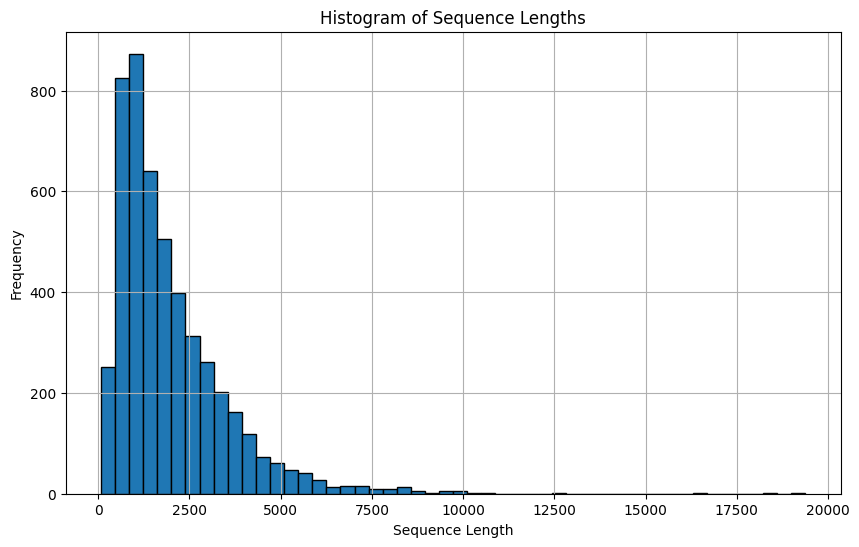

In [33]:
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(sequence_lengths, bins=50, edgecolor='black')
plt.title('Histogram of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [34]:
len([s for s in sequence_lengths if s>2096])

1703

In [35]:
np.mean([s-2096 for s in sequence_lengths if s>2096])

1489.3669994128009

In [36]:
len([s for s in sequence_lengths if s<1024])

1500

In [37]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8
torch.manual_seed(123)

# Create training set DataLoader
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

# Create validation set DataLoader
val_loader = DataLoader(
    dataset=validation_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False,
)

# Create test set DataLoader
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False,
)

In [38]:
# Ensure DataLoaders are working as expected
for input_batch, target_batch in train_loader:
    pass
print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Input batch dimensions: torch.Size([8, 1024])
Label batch dimensions torch.Size([8])


In [39]:
# Check total number of batches in each dataset
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

428 training batches
62 validation batches
123 test batches


## 13. Load the pretrained model

In [40]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"
BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

In [41]:
from gpt_download import download_and_load_gpt2

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


GPTModel(
  (token_embedding): Embedding(50257, 768)
  (positional_embedding): Embedding(1024, 768)
  (drop_embedding): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAttention(


In [42]:
text_1 = "Every effort moves you"
token_ids = generate(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


In [43]:
# Test if model can already classify a turksh news (without finetuning)
text_2 = (
    "Aşağıdaki haber metninin kategorisi nedir? "
    " Bundan yaklaşık 30 yıl önce yapay zekânın hayatımızın her alanına gireceğini, bağışıklık sistemi hücrelerinin kanser tedavisinde kilit yöntem olacağını, beyin hücresi atlası çıkarılacağını, gen tedavilerinin yaygınlaşacağını ve uzay turizmi gibi kavramlardan bahsedeceğimizi söyleseler bir bilimkurgu filminden bahsedildiğini düşünürdük. "
)
token_ids = generate(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Aşağıdaki haber metninin kategorisi nedir?  Bundan yaklaşık 30 yıl önce yapay zekânın hayatımızın her alanına gireceğini, bağışıklık sistemi hücrelerinin kanser tedavisinde kilit yöntem olacağını, beyin hücresi atlası çıkarılacağını, gen tedavilerinin yaygınlaşacağını ve uzay turizmi gibi kavramlardan bahsedeceğimizi söyleseler bir bilimkurgu filminden bahsedildiğini düşünürdük. ışıkılıkılıkılıkılıkılı


## 14. Implement a classification head

In [44]:
# Freeze all model layers first
for param in model.parameters():
  param.requires_grad = False

In [45]:
# Add a classification head
torch.manual_seed(123)
num_classes = 7
model.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"], # 768
    out_features=num_classes,           # 7
)

In [46]:
num_classes

7

In [47]:
# Make the final transformer block trainable
for param in model.trf_blocks[-1].parameters():
  param.requires_grad = True

# Make the final LayerNorm trainable
for param in model.final_norm.parameters():
  param.requires_grad = True

In [48]:
# Test out the classification head!
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)

with torch.no_grad():
  outputs = model(inputs)

print(f"Outputs:\n {outputs}")
print(f"Outputs dimensions: {outputs.shape}")



Outputs:
 tensor([[[-1.6074,  1.0019, -0.0112, -0.3821, -0.1330, -0.9867,  2.2737],
         [-3.7455,  7.4664,  2.1972,  0.0751,  2.2227, -3.3227,  6.0291],
         [-2.2881,  6.6165,  2.7453, -0.7302,  2.2822, -3.3142,  5.6626],
         [-3.6204,  4.0018,  2.2423, -1.2131,  0.0501, -4.7189,  5.8334]]])
Outputs dimensions: torch.Size([1, 4, 7])


In [49]:
# Get the classification prediction, which is the last token in the output
print(f"Last output token: {outputs[:, -1, :]}")

Last output token: tensor([[-3.6204,  4.0018,  2.2423, -1.2131,  0.0501, -4.7189,  5.8334]])


In [50]:
target_batch

tensor([4, 2, 4, 5, 4, 6, 0, 6])

## 15. Implement loss functions

In [51]:
def calculate_loss_batch(input_batch, target_batch, model, device):
  input_batch, target_batch = input_batch.to(device), target_batch.to(device)
  logits = model(input_batch)[:, -1, :] # Grab logits of last output token only!
  loss = torch.nn.functional.cross_entropy(logits, target_batch)
  return loss

In [52]:
def calculate_loss_loader(data_loader, model, device, num_batches=None):
  total_loss = 0
  if len(data_loader) == 0:
    return float("nan")
  elif num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))

  # Loop through data loader and calculate loss
  for index, (input_batch, target_batch) in enumerate(data_loader):
    if index < num_batches:
      loss = calculate_loss_batch(input_batch, target_batch, model, device)
      total_loss += loss.item()
    else:
      break
  return total_loss / num_batches


In [53]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Calculate loss of each loader
with torch.no_grad():
  train_loss = calculate_loss_loader(train_loader, model, device, num_batches=5)
  val_loss = calculate_loss_loader(val_loader, model, device, num_batches=5)
  test_loss = calculate_loss_loader(test_loader, model, device, num_batches=5)


In [55]:
print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 6.694
Validation loss: 5.884
Test loss: 5.958


## 16. Implement evaluation functions

In [56]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
  # Put model in evaluation mode
  model.eval()
  with torch.no_grad():
    train_loss = calculate_loss_loader(train_loader, model, device, num_batches=eval_iter)
    val_loss = calculate_loss_loader(val_loader, model, device, num_batches=eval_iter)

  # Put model back in training mode
  model.train()
  return train_loss, val_loss

In [57]:
def calculate_accuracy_loader(data_loader, model, device, num_batches=None):
  # Put model in evaluation mode
  model.eval()
  correct_predictions, num_examples = 0, 0

  if num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))

  for index, (input_batch, target_batch) in enumerate(data_loader):
    if index < num_batches:
      input_batch, target_batch = input_batch.to(device), target_batch.to(device)

      with torch.no_grad():
        logits = model(input_batch)[:, -1, :] # Last output token only
      predicted_labels = torch.argmax(logits, dim=-1)

      num_examples += predicted_labels.shape[0]
      correct_predictions += (predicted_labels == target_batch).sum().item()

  return correct_predictions / num_examples


## 17. Implement finetuning function

In [58]:
def train_classifier(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs,
    eval_freq,
    eval_iter,
    tokenizer,
  ):

  # Initialize lists to track losses and examples seen
  train_losses, val_losses, train_accs, val_accs = [], [], [], []
  examples_seen, global_step = 0, -1

  # Main training loop
  for epoch in range(num_epochs):
    model.train()

    for input_batch, target_batch in train_loader:
      optimizer.zero_grad()
      loss = calculate_loss_batch(input_batch, target_batch, model, device)
      loss.backward()
      optimizer.step()
      examples_seen += input_batch.shape[0]
      global_step += 1

      if global_step % eval_freq == 0:
        train_loss, val_loss = evaluate_model(
          model, train_loader, val_loader, device, eval_iter
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Ep {epoch+1} (Step {global_step:06d}): "
              f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}"
              )
    train_accuracy = calculate_accuracy_loader(
        train_loader, model, device, num_batches=eval_iter
    )

    val_accuracy = calculate_accuracy_loader(
        val_loader, model, device, num_batches=eval_iter
    )

    print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
    print(f"Validation accuracy: {val_accuracy*100:.2f}%")

    train_accs.append(train_accuracy)
    val_accs.append(val_accuracy)
  return train_losses, val_losses, train_accs, val_accs, examples_seen

## 18. Train the model!

In [59]:
import time

start_time = time.time()
torch.manual_seed(123)

# Create optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

# Set training epochs
num_epochs = 5

# Train the model
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=50,
    eval_iter=5,
    tokenizer=tokenizer,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 4.889, Val loss 5.657
Ep 1 (Step 000050): Train loss 2.180, Val loss 2.246
Ep 1 (Step 000100): Train loss 1.969, Val loss 2.056
Ep 1 (Step 000150): Train loss 1.994, Val loss 1.955
Ep 1 (Step 000200): Train loss 2.080, Val loss 1.964
Ep 1 (Step 000250): Train loss 1.903, Val loss 1.958
Ep 1 (Step 000300): Train loss 1.839, Val loss 1.902
Ep 1 (Step 000350): Train loss 1.943, Val loss 1.878
Ep 1 (Step 000400): Train loss 2.000, Val loss 1.887
Training accuracy: 20.00% | Validation accuracy: 22.50%
Ep 2 (Step 000450): Train loss 1.960, Val loss 1.854
Ep 2 (Step 000500): Train loss 1.990, Val loss 1.867
Ep 2 (Step 000550): Train loss 1.838, Val loss 1.871
Ep 2 (Step 000600): Train loss 1.828, Val loss 1.842
Ep 2 (Step 000650): Train loss 1.798, Val loss 1.856
Ep 2 (Step 000700): Train loss 1.754, Val loss 1.849
Ep 2 (Step 000750): Train loss 1.780, Val loss 1.846
Ep 2 (Step 000800): Train loss 1.825, Val loss 1.836
Ep 2 (Step 000850): Train loss 1.942, Val l

## 19. Visualize the training loss

In [60]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))


    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()


    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

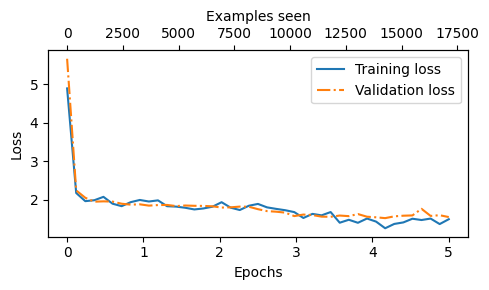

In [61]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

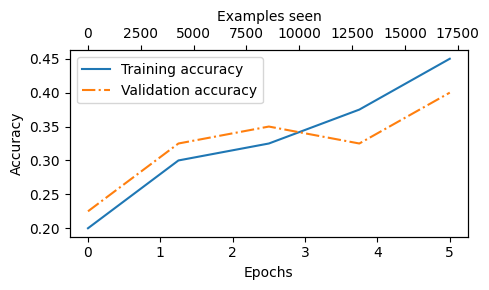

In [62]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [63]:
train_accuracy = calculate_accuracy_loader(train_loader, model, device)
val_accuracy = calculate_accuracy_loader(val_loader, model, device)
test_accuracy = calculate_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 42.20%
Validation accuracy: 33.47%
Test accuracy: 35.00%


## 20. Use the fintuned model

In [64]:
def classify(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    input_ids = tokenizer.encode(text)
    supported_context_length = model.positional_embedding.weight.shape[1]

    input_ids = input_ids[:min(max_length, supported_context_length)]

    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)


    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]
    predicted_label = torch.argmax(logits, dim=-1).item()

    predicted_category = id_to_category[predicted_label]

    return predicted_category

In [65]:
small_test_data = [
 {"text":"""Son yıllarda internetin en fazla konuşulan kişilerinden olan Bryan Johnson, kendini ölümsüz kılmak amacıyla oluşturduğu akıl almaz
 beslenme ve sağlık rutiniyle gündemden düşmüyor. Kendi bedeni üzerinde yapabileceği deneylerin sonuna gelen Johnson, programını daha fazla kişiye açtı
 ve çok kısa sürede büyük ilgi gördü. Peki bilim insanları ve doktorların eleştiri ve uyarılarına konu olan bu programda ne var?
 Neden tüm uyarılara rağmen Johnson'ın protokolünü bu kadar popüler oldu?""",
 "category":"dunya"},
 {"text":"""Ağız ve diş sağlığının bozulması sonucunda meydana gelen diş kayıpları, konuşma ve kelimeleri telaffuz etmede zorluk yaşattığı gibi sindirim
 sisteminde sorunlara da neden oluyor. Ama hepsi bu değil. Uzmanlara göre dişte oluşan problemler başta kalp rahatsızlıkları olmak üzere akciğer hastalıkları,
  diyabet hatta son araştırmalara göre Alzheimer’ın oluşmasında etkili. Peki dişlerin bu hastalıklarla ilgisi ne? Ağız hijyeni bu sorunların önüne geçmede
  ne kadar etkili?
 Uzmanlarla mercek altına aldık.""",
  "category":"saglik"},
 {"text":"""Bundan yaklaşık 30 yıl önce yapay zekânın hayatımızın her alanına gireceğini, bağışıklık sistemi hücrelerinin kanser tedavisinde
 kilit yöntem olacağını, beyin hücresi atlası çıkarılacağını, gen tedavilerinin yaygınlaşacağını ve uzay turizmi gibi kavramlardan bahsedeceğimizi söyleseler
  bir bilimkurgu filminden bahsedildiğini düşünürdük. Yaşadığımız aşırı doğa olaylarına ve iklim krizine bakarsak da bunun distopik bir film olacağını
  zannederdik. 2023 yılı özellikle sağlık alanındaki bilimsel gelişmeler yönünden verimli ancak doğaya verdiğimiz tahribat açısından umutsuz geçti.
 Peki, 2024’te ve sonraki dönemde bizi neler bekliyor? Bilim insanlarına sorduk.""" ,
 "category":"teknoloji"},
 {"text":"""Trendyol Süper Lig'in 21. haftasında deplasmanda Trabzonspor ile karşılaşacak olan Galatasaray'da kafile açıklandı. Mauro Icardi kadroda yer aldı.
Süper Lig'in 21. haftasında yarın deplasmanda Trabzonspor ile karşı karşıya gelecek olan Galatasaray'da kafile kadrosu belli oldu. İki gündür takımla çalışan Mauro Icardi kadroda yer aldı.""",
  "category":"spor"},
 {"text": """Milyonlarca memur ve emekli maaş zammının yüzde 49.25 olarak belirlenmesinin ardından maaş farklarını beklemeye başladı.
 Memur ve memur emeklileri,
  zamlı maaşlarını ve enflasyon farkları 15 Ocak'tan itibaren alacak.
  """,
  "category":"ekonomi"}

]

In [67]:
for row in small_test_data:
  print(f"Text: {row['text']}")
  print(f"Classification: {classify(row['text'], model, tokenizer, device, max_length=train_dataset.max_length)}")
  print()

Text: Son yıllarda internetin en fazla konuşulan kişilerinden olan Bryan Johnson, kendini ölümsüz kılmak amacıyla oluşturduğu akıl almaz
 beslenme ve sağlık rutiniyle gündemden düşmüyor. Kendi bedeni üzerinde yapabileceği deneylerin sonuna gelen Johnson, programını daha fazla kişiye açtı
 ve çok kısa sürede büyük ilgi gördü. Peki bilim insanları ve doktorların eleştiri ve uyarılarına konu olan bu programda ne var?
 Neden tüm uyarılara rağmen Johnson'ın protokolünü bu kadar popüler oldu?
Classification: dunya

Text: Ağız ve diş sağlığının bozulması sonucunda meydana gelen diş kayıpları, konuşma ve kelimeleri telaffuz etmede zorluk yaşattığı gibi sindirim
 sisteminde sorunlara da neden oluyor. Ama hepsi bu değil. Uzmanlara göre dişte oluşan problemler başta kalp rahatsızlıkları olmak üzere akciğer hastalıkları,
  diyabet hatta son araştırmalara göre Alzheimer’ın oluşmasında etkili. Peki dişlerin bu hastalıklarla ilgisi ne? Ağız hijyeni bu sorunların önüne geçmede
  ne kadar etkili?
 Uzma